## Import Libraries & Data

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
from math import sqrt
import collections
import re
import jellyfish # for edit and jaro distances
from nltk.stem.snowball import SnowballStemmer # for stemming
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt

#Stemmer
stemmer = SnowballStemmer("english") # the best performing stemmer

encoding = "ISO-8859-1"
train_data = pd.read_csv('data/train.csv', encoding=encoding)
test_data = pd.read_csv('data/test.csv', encoding=encoding)
desc_data = pd.read_csv('data/product_descriptions.csv', encoding=encoding)
attrs = pd.read_csv('data/attributes.csv', encoding=encoding)


## Preprocessing Functions

In [3]:
def tokenize(text):
    '''
    Description: Splits a string into a list of tokens according to regex matching chosen.
    Input:       Text string
    Output:      A list of tokens
    '''
    
    text = re.sub("(?<=\\d)[x*](?=\\d)",r' x ',text) # split substrings like '1x2' or '1*2' into '1 x 2'
    text = re.sub(r"(\d+)([a-zA-Z_]+)", r"\1 \2", text) # split substrings like '8ft' into '8 ft'  ((\d+)((?!x)\w+))
    token = re.compile("\d+[\.\/]\d+|[\w]+(?=n't)|n't|\'m|\'ll\'re\'d|[\w]+|\?\!|[.?!;,\-\(\)—\:']")
    stop = ['(',')','','!','.',';',',','[',']','!','?',"'",'-','—','"','\\'] # tokens to be removed from tokens
    #'/','d','ll','a','o','m','s','y','an','the','be','ve','re','by','such','of'
    return [f for f in token.findall(text) if f not in stop]


def stem_and_lower(cell_val):
    '''
    Description: Applies stemming on specific value of a dataframe cell
                 and turns all of the letters to lowercase
    Input:       Text string
    Output:      Same Text Stemmed and Lowercased 
    '''
    
    return " ".join([stemmer.stem(word) for word in tokenize(cell_val.lower())])

def count_words(query,doc):
    '''
    Description: Finds the frequency of a query's words in a document
                 E.g. it can return the total number the words of 
                 search term appear in product title/product description
    Input:       2 Texts
    Output:      Length of the Intersection of their words 
    '''
    
    total=0
    cnt= (collections.Counter(tokenize(doc)))
    for word in tokenize(query):
        total+=cnt[str(word)]
    return total

def word_percentage(query,doc):
    '''
    Description: Finds the percentage of the words in the query tha exist in a given document 
    Input:       2 Text Documents
    Output:      Percentage of words of document one that exist in document two
    '''
    
    total_query_words = len(query)
    doc_words = tokenize(doc)
    count_words = 0
    for word in tokenize(query):
        if word in doc_words:
            count_words += 1
    
    return count_words/total_query_words
        
    
def jaccard_coefficient(text1,text2):
    '''
    Description: Finds Jaccard Similarity among 2 texts
    Input:       2 Text Documents
    Output:      A float number from 0 to 1, stating the difference among the 2 text documents
    '''
    
    text1=set(tokenize(text1))
    text2=set(tokenize(text2))
    return (len(text1 & text2))/(len(text1|text2))
    
def add_product_frequency(df):
    '''Description: Finds the number of appearances of each product in our data
       Input:       Our dataset that connects products and queries
       Output:      Dataframe with an appended number to each row accompanying the products
    '''
    
    df['product_count'] = df.groupby(['product_uid'])['id'].transform('count')
    return df

def add_product_description(df1,df2):
    '''
    Description: merging dataframes on a specific ('product_uid') key
                 in order to include product_description in query data
    Input:       2 dataframes df1,df2
    Output:      A dataframe that includes information of both
    '''
    
    return pd.merge(df1, df2, how='left', on='product_uid')


def add_brand_name(df,brand_attrs):

    df = pd.merge(df, brand_attrs, how='left', on='product_uid')
    df = df.rename(columns={'value': 'brand_name'})
    df.fillna('unknown', inplace=True)
    return df

def add_lengths(df):
    ''' 
    Description: Adding the lengths of some informative columns as features
    Input:       A data frame
    Output:      The same data frame with appended values in each row
    '''
    
    df['query_length'] = df['search_term'].map(lambda x:len(tokenize(x)))
    df['title_length'] = df['product_title'].map(lambda x:len(tokenize(x)))
    df['brand_name_length'] = df['brand_name'].map(lambda x:len(tokenize(x)))
    df['product_description_length'] = df['product_description'].map(lambda x:len(tokenize(x)))
    
    return df 

def add_similarity_measures(df):
    '''
    Description: add columns regarding similarity measure applied among user queries,
                 product title, product description and product brand name
    Input:       A dataframe 
    Output:      Updated dataframe with similarity feature representations
    '''
    
    #dummy column in order to find title & description relevances with query
    df['query_title_description_brand'] = df['search_term']+"\t"+df['product_title']+"\t"+df['product_description']+"\t"+df['brand_name']
    
    #Check if search term words exist in product title
    df['title_includes_query'] = df['query_title_description_brand'].map(lambda x:count_words(x.split('\t')[0],x.split('\t')[1]))
    df['description_includes_query'] = df['query_title_description_brand'].map(lambda x:count_words(x.split('\t')[0],x.split('\t')[2]))
    df['brand_includes_query'] = df['query_title_description_brand'].map(lambda x:count_words(x.split('\t')[0],x.split('\t')[3]))
    
    #Check separately if the last word of the query belongs to title / description
    df['query_last_word_in_title'] = df['query_title_description_brand'].map(lambda x:count_words(tokenize(x.split('\t')[0])[-1],x.split('\t')[1]))
    df['query_last_word_in_description'] = df['query_title_description_brand'].map(lambda x:count_words(tokenize(x.split('\t')[0])[-1],x.split('\t')[2]))
    
    #Jaccard coefficient between search term-product title and search term-product_description pairs
    df['jaccard_coefficient_query_title'] = df['query_title_description_brand'].map(lambda x:jaccard_coefficient(x.split('\t')[0],x.split('\t')[1]))
    df['jaccard_coefficient_query_description'] = df['query_title_description_brand'].map(lambda x:jaccard_coefficient(x.split('\t')[0],x.split('\t')[2]))
    #Jaccard coefficient between search term-brand name
    df['jaccard_coefficient_query_brand'] = df['query_title_description_brand'].map(lambda x:jaccard_coefficient(x.split('\t')[3],x.split('\t')[0]))
    
    #Edit Distance between search term and product title('Levenshtein distance')
    df['query_title_edit_distance'] = df['query_title_description_brand'].map(lambda x:jellyfish.levenshtein_distance(x.split('\t')[0],x.split('\t')[1]))
    df['query_description_edit_distance'] = df['query_title_description_brand'].map(lambda x:jellyfish.levenshtein_distance(x.split('\t')[0],x.split('\t')[2]))
    
    #Jaro Distance between search term and product title('Levenshtein distance')
    df['query_title_jaro_distance'] = df['query_title_description_brand'].map(lambda x:jellyfish.jaro_distance(x.split('\t')[0],x.split('\t')[1]))
    df['query_description_jaro_distance'] = df['query_title_description_brand'].map(lambda x:jellyfish.jaro_distance(x.split('\t')[0],x.split('\t')[2]))
    
    #Drop dummy column
    df = df.drop(['query_title_description_brand'], 1)
    return df



def stem_dataset(df):
    '''
    Description: Stemming values of specific columns 
    Input:       Dataframe to stem
    Output:      Same Dataframe with the columns specified below
                 being modified (stemmed)
    '''
    
    # Stemming search_term,product_title,product_description,brand_name
    df['search_term'] = df['search_term'].map(lambda x:stem_and_lower(x))  #.apply(lambda x: stemmer.stem(x))
    df['product_title'] = df['product_title'].map(lambda x:stem_and_lower(x))  #.apply(lambda x: stemmer.stem(x))
    df['product_description'] = df['product_description'].map(lambda x:stem_and_lower(x)) #.apply(lambda x: stemmer.stem(x))
    df['brand_name'] = df['brand_name'].map(lambda x:stem_and_lower(x))

    return df


def preprocessing(data,desc_data,attrs,is_train):
    '''
    Description: Applies all the preprocessing functions to input dataset (train_X / test_X)
    
    Input:       data: Dataframe of dataset & 
                 desc_data: Dataframe of product description
                 is_train:  Boolean that specifies if we deal with train or test set
    Output:      Preprocessed dataset
    '''
    if is_train:
        data = train_data.drop(['relevance'], 1)
        
    #Adding product description
    data = add_product_description(data,desc_data)

    #Adding brand name from attributes
    brand_attrs = attrs[attrs.name.isin(['MFG Brand Name'])]
    brand_attrs = brand_attrs.drop(['name'],axis=1)
    data = add_brand_name(data,brand_attrs)

    

    data = add_lengths(data)

    data = add_product_frequency(data)

    data = stem_dataset(data)

    data = add_similarity_measures(data)
    
    #Drop data that won't be used in the fitting
    
    data = data.drop(['search_term','product_title','product_description','brand_name'],axis=1)
    data = data.drop_duplicates()

    return data


## Preprocess and Feature Engineering

In [4]:
#Keep training labels on train_Y    
train_Y = train_data['relevance']
#Preprocess train and test data
train_X = preprocessing(train_data,desc_data,attrs,True)
test_X = preprocessing(test_data,desc_data,attrs,False)



## Load Kaggle Solutions and Prepare Train/Test Set form

In [5]:
#Loading Solutions from Kaggle
sol = pd.read_csv('data/solution.csv')
sol_not_ign=sol[(sol['Usage'])!='Ignored']

#Prepare the form of training data
X_train = train_X.values
y_train = train_Y.values


#Add relevance label to my test_set
test_XY = pd.merge(sol_not_ign,test_X, on='id')
y_gold = test_XY['relevance'].values
X_test = (test_XY.drop(['relevance','Usage'],axis=1)).values


## Cross Validation - Gridsearch

In [8]:
from sklearn import pipeline, grid_search
gbr = GradientBoostingRegressor(random_state = 2017,subsample=0.8, verbose = 1)

param_grid = {'n_estimators':[100,200,300],'max_depth': [3,4,5,6]}
model = grid_search.GridSearchCV(estimator = gbr, param_grid = param_grid, n_jobs = -1,cv = 3, verbose = 20,scoring='neg_mean_squared_error')
model.fit(X_train, y_train)

print("Best parameters found by grid search for GBR:")
print(model.best_params_)
best_cv_rmse = sqrt(abs(model.best_score_))
best_cv_rmse
print("Best CV score (RMSE) for GBR:")
print(best_cv_rmse)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Paralle

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2788           0.0070            8.88s
         2           0.2725           0.0056            8.22s
         3           0.2680           0.0049            8.46s
         4           0.2628           0.0040            8.08s
         5           0.2596           0.0037            7.88s
         6           0.2577           0.0029            8.07s
         7           0.2546           0.0026            8.01s
         8           0.2515           0.0027            7.83s
         9           0.2493           0.0022            7.88s
        10           0.2474           0.0017            7.68s
        20           0.2360           0.0007            6.80s
        30           0.2320           0.0002            5.82s
        40           0.2300           0.0002            4.97s
        50           0.2277           0.0001            4.13s
        60           0.2278           0.0001            3.27s
       

In [9]:
from sklearn import pipeline, grid_search
ert = ExtraTreesRegressor(random_state = 2017,verbose=1)

param_grid = {'n_estimators':[25,50,100,200],'max_depth': [5,6,7,8]}
model = grid_search.GridSearchCV(estimator = ert, param_grid = param_grid, n_jobs = -1,cv = 3, verbose = 20,scoring='neg_mean_squared_error')
model.fit(X_train, y_train)

print("Best parameters found by grid search for ERT:")
print(model.best_params_)
best_cv_rmse = sqrt(abs(model.best_score_))
best_cv_rmse
print("Best CV score(RMSE) for ERT:")
print(best_cv_rmse)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.3s
[Paralle

Best parameters found by grid search for ERT:
{'n_estimators': 25, 'max_depth': 8}
Best CV score(RMSE) for ERT:
0.48999603611634274


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.6s finished


In [10]:
from sklearn import pipeline, grid_search
svr_model = SVR()

param_grid = {'C':[1,10,100,1000],'epsilon': [0.1,0.2,0.3]}
model = grid_search.GridSearchCV(estimator = svr_model, param_grid = param_grid, n_jobs = -1,cv = 3, verbose = 20,scoring='neg_mean_squared_error')
model.fit(X_train, y_train)

print("Best parameters found by grid search for SVM:")
print(model.best_params_)
best_cv_rmse = sqrt(abs(model.best_score_))
best_cv_rmse
print("Best CV score(RMSE) for SVM:")
print(best_cv_rmse)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 33.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 36.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 46.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 52.8min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 53.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 56.2min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 66.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 68.9min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 70.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 72.4min
[Paralle

Best parameters found by grid search for SVM:
{'epsilon': 0.3, 'C': 10}
Best CV score(RMSE) for SVM:
0.540592733667966


## Models (Random Forest, Gradient Boosting,SVM etc.)

### SVM

In [11]:
svr_model = SVR(C = 100, epsilon=0.3, gamma='auto')
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)

rmse = sqrt(mean_squared_error(y_gold,y_pred))  
rmse

0.5357064963272871

### Extremely Randomized Trees

In [13]:
ert = ExtraTreesRegressor(n_estimators=200,max_depth=8,verbose=1)
ert.fit(X_train, y_train)
y_pred = ert.predict(X_test)

rmse = sqrt(mean_squared_error(y_gold,y_pred)) 
rmse

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   13.6s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished


0.4844988405933885

### Gradient Bossting Regression (with / without Bagging)

In [6]:
gbr = GradientBoostingRegressor(n_estimators=300,max_depth=4,subsample=1, random_state = 2017, verbose = 1)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

rmse = sqrt(mean_squared_error(y_gold,y_pred)) 
rmse


      Iter       Train Loss   Remaining Time 
         1           0.2769           41.25s
         2           0.2701           40.53s
         3           0.2644           42.04s
         4           0.2597           41.38s
         5           0.2558           41.16s
         6           0.2524           41.68s
         7           0.2495           41.68s
         8           0.2471           41.29s
         9           0.2450           41.01s
        10           0.2432           41.14s
        20           0.2324           38.76s
        30           0.2282           36.11s
        40           0.2261           34.04s
        50           0.2246           32.79s
        60           0.2237           31.33s
        70           0.2229           29.43s
        80           0.2221           27.84s
        90           0.2214           26.34s
       100           0.2209           24.74s
       200           0.2158           11.79s
       300           0.2115            0.00s


0.4791155474928127

## Error Analysis

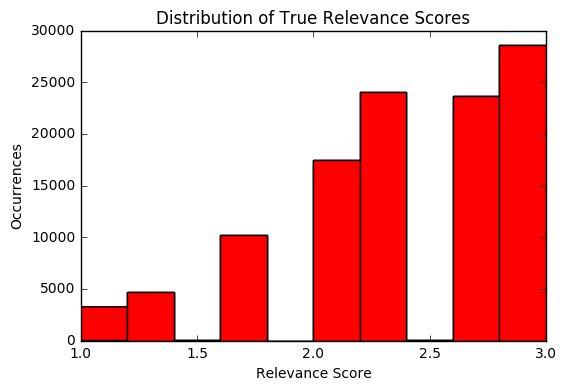

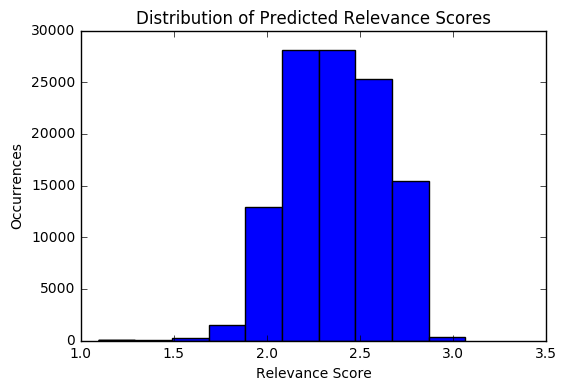

In [10]:
plt.hist(y_gold)
plt.title('Distribution of True Relevance Scores')
plt.xlabel('Relevance Score')
plt.ylabel('Occurrences')
plt.savefig('y_gold_hist.png', dpi=100)
plt.show()

plt.hist(y_pred)
plt.title('Distribution of Predicted Relevance Scores')
plt.xlabel('Relevance Score')
plt.ylabel('Occurrences')
plt.savefig('y_pred_hist.png', dpi=100)
plt.show()